In [151]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

In [152]:
def Gaussian_pdf(mu, sigma, stds=4):
    x = np.linspace(mu - stds*sigma, mu + stds*sigma, 100)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return x, y

In [153]:
def get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=.9):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    T = (2*np.pi)/omega
    expon = np.exp(-T/tau_m)
    frac_denom = (1 - expon)*R_m*I_osc*A
    
    I_min = (V_th/frac_denom - 1)*I_osc*A
    I_max = (V_th/frac_denom + 1)*I_osc*A
    
    corr_frac = (1 - range_frac) * (I_max - I_min) / 2
    I_min += corr_frac
    I_max -= corr_frac
    
    return I_min, I_max

In [154]:
def get_snr_corr_factor(tau_m, f):
    delta_Is = (1 - np.exp(-1/tau_m)) / (1 - np.exp(-1/(f*tau_m)))
    delta_Iosc = np.sqrt(1 + (tau_m*2*np.pi*f)**2) / np.sqrt(1 + (tau_m*2*np.pi)**2)
    snr = delta_Is * delta_Iosc    # delta_Is + delta_Iosc ??
    return snr

def get_avg_Is(V_th, R_m, tau_m, f):
    Is_bar = V_th / ( R_m * (1 - np.exp(-1/(f*tau_m))) )
    return Is_bar

In [155]:
def compute_Iosc(v_osc_amp, R_m, tau_m, omega):
    I_osc = abs(v_osc_amp) * np.sqrt((tau_m*omega)**2 + 1) / R_m
    return I_osc

In [156]:
def eta_to_sigma_w(eta, V_th, tau_m, f):
    snr = get_snr_corr_factor(tau_m, f)
    return (eta * snr * V_th) / np.sqrt(tau_m)

def sigma_w_to_eta(sigma_w, V_th, tau_m, f):
    snr = get_snr_corr_factor(tau_m, f)
    return (sigma_w * np.sqrt(tau_m)) / (V_th * snr)

In [157]:
def compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    ph = -np.arctan(tau_m*omega) - np.pi
    m = I_s/(A*I_osc)
    T = (2*np.pi)/omega
    b = V_th/(R_m*I_osc*A*(1 - np.exp(-T/tau_m)))
    phi = np.nan_to_num(-np.arccos(b - m) - ph)
    return phi

def compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N):
    phi_i = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    snr = get_snr_corr_factor(tau_m, f)
    numerator = omega**2 * eta**2 * snr**2 * V_th**2 * (1 - np.exp(-2/(f*tau_m))) * tau_m**2
    denominator = 2 * N * (-V_th + R_m * I_s - R_m * I_osc * np.cos(phi_i))**2
    var =  numerator/denominator
    return var

def get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N):
    omega = 2 * np.pi * f
    I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    means = [compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc) for I_s in Is_range]
    variances = [compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N) for I_s in Is_range]
    return np.array(means), np.array(variances)

In [158]:
# Params
N = 1                  # number of neurons
R_m = 142 * 1e6        # MOmh
V_th = 15 * 1e-3       # mV
tau_m = 24 * 1e-3      # ms
f = 5                  # Hz

#eta = 0.14             # a.u  //  sigma_w = 0.012-0.015 V/sqrt(s), acoording to Lansky et al (2006). eta=0.124-0.155 a.u.
eta = sigma_w_to_eta((0.012+0.015)/2, V_th, tau_m, f)

omega = 2 * np.pi * f  # Hz
v_osc_amp = 5 * 1e-3   # mV
#I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, f)
I_osc = 40 * 1e-12     # pA
M = 5                  # number input levels
range_frac = 0.75
I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
Is_range = np.linspace(I_min, I_max, M)

#phis_0 = list(map(lambda I_s : compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc), Is_range))

In [159]:
Is_range

array([8.17050654e-11, 9.36821327e-11, 1.05659200e-10, 1.17636267e-10,
       1.29613335e-10])

In [160]:
means, variances = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)

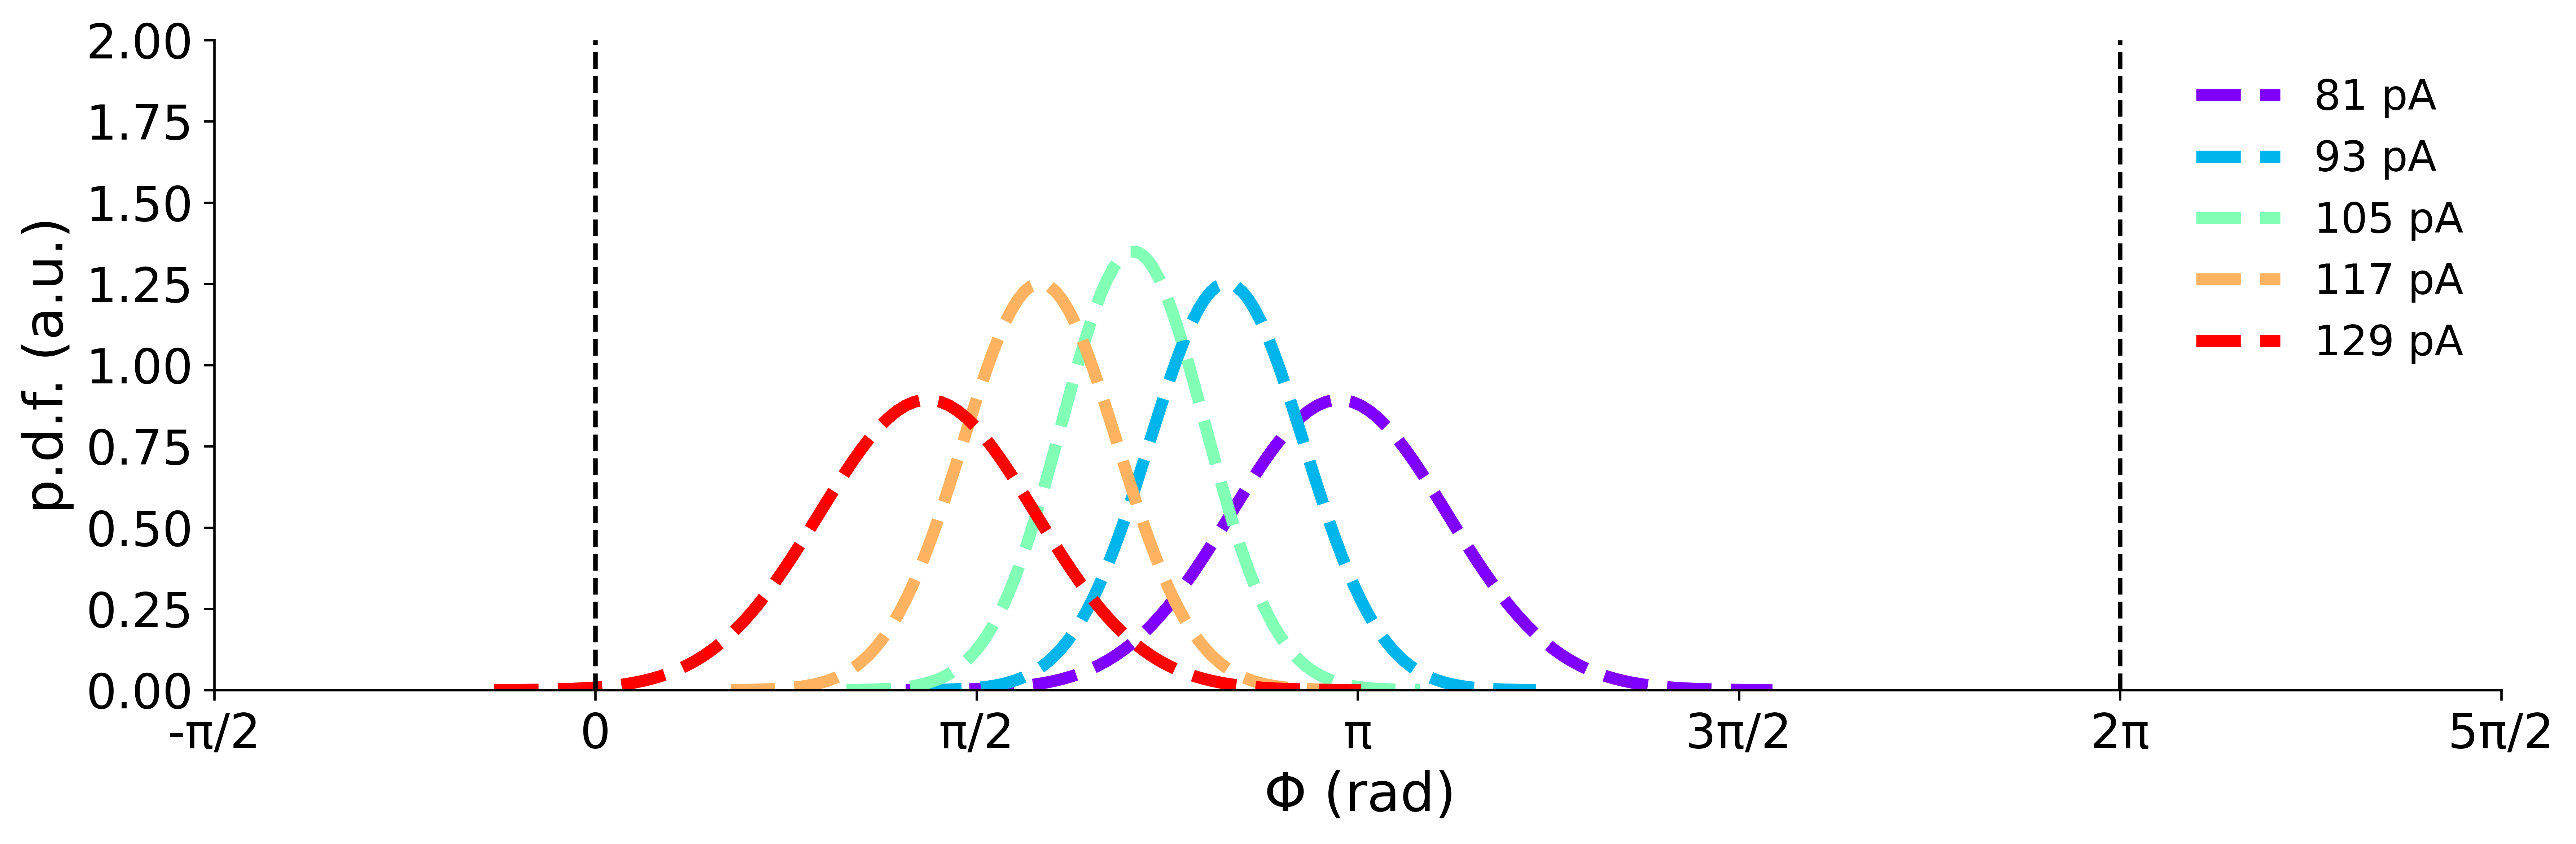

In [161]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
#plt.savefig('distr.png', dpi=600)
plt.show()

In [162]:
fs = [1, 5, 30, 100]
etas = [0.05, 0.1, 0.2, 0.4]
sigmas_w = eta_to_sigma_w(np.array(etas), V_th, tau_m, f)
alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas):
    for j, f in enumerate(fs):
        means, variances = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)
        #print(variances)
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='--', color=c[k], label=str(int(Is*1e12))+" pA")
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
        
plt.tight_layout()

#plt.savefig('phase_distr_th.png', dpi=600)

plt.show()

## Info rate

In [209]:
def approx_mi(means, variances):
    return np.log(np.mean(variances) + np.var(means)) - np.mean(np.log(variances))

def numerical_mi(means, variances, n_samples=int(1e4)):
    samples = []
    for mean, var in zip(means, variances):
        samples.extend(norm.rvs(loc=mean, scale=np.sqrt(var), size=n_samples))
    histogram, _ = np.histogram(samples, bins='auto', density=True)
    histogram = histogram + np.finfo(float).eps
    H_Y = -np.sum(histogram * np.log(histogram) * np.diff(np.linspace(np.min(samples), np.max(samples), len(histogram) + 1)))

    H_Y_given_X = np.mean([0.5 * np.log(2 * np.pi * np.e * var) for var in variances])

    return H_Y - H_Y_given_X

def get_R(mis, fs, tau_x, norm=True):
    corr_fact_sampling = (1 - np.exp(-(1/(fs*tau_x))))
    info_rate = mis * fs[np.newaxis, :] * corr_fact_sampling[np.newaxis, :]
    
    if norm:
        info_rate_norm = np.zeros_like(info_rate)  
        for index, row in enumerate(info_rate):
            info_rate_norm[index, :] = row/np.max(row)
        info_rate = info_rate_norm
        
    return info_rate

In [166]:
# Params
R_m = 142 * 1e6        # MOmh
V_th = 15 * 1e-3       # mV
tau_m = 24 * 1e-3      # ms
omega = 2 * np.pi * f  # Hz
v_osc_amp = 5 * 1e-3   # mV
range_frac = 0.75

In [167]:
M = 10
res = 200
fs = np.linspace(1, 100, res)
etas = np.linspace(0.0001, 0.5, res)
mis_approx = np.zeros((res,res))
mis_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        means, variances = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)
        mis_approx[i, j] = approx_mi(means, variances)
        mis_numerical[i, j] = numerical_mi(means, variances, n_samples=int(1e4))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


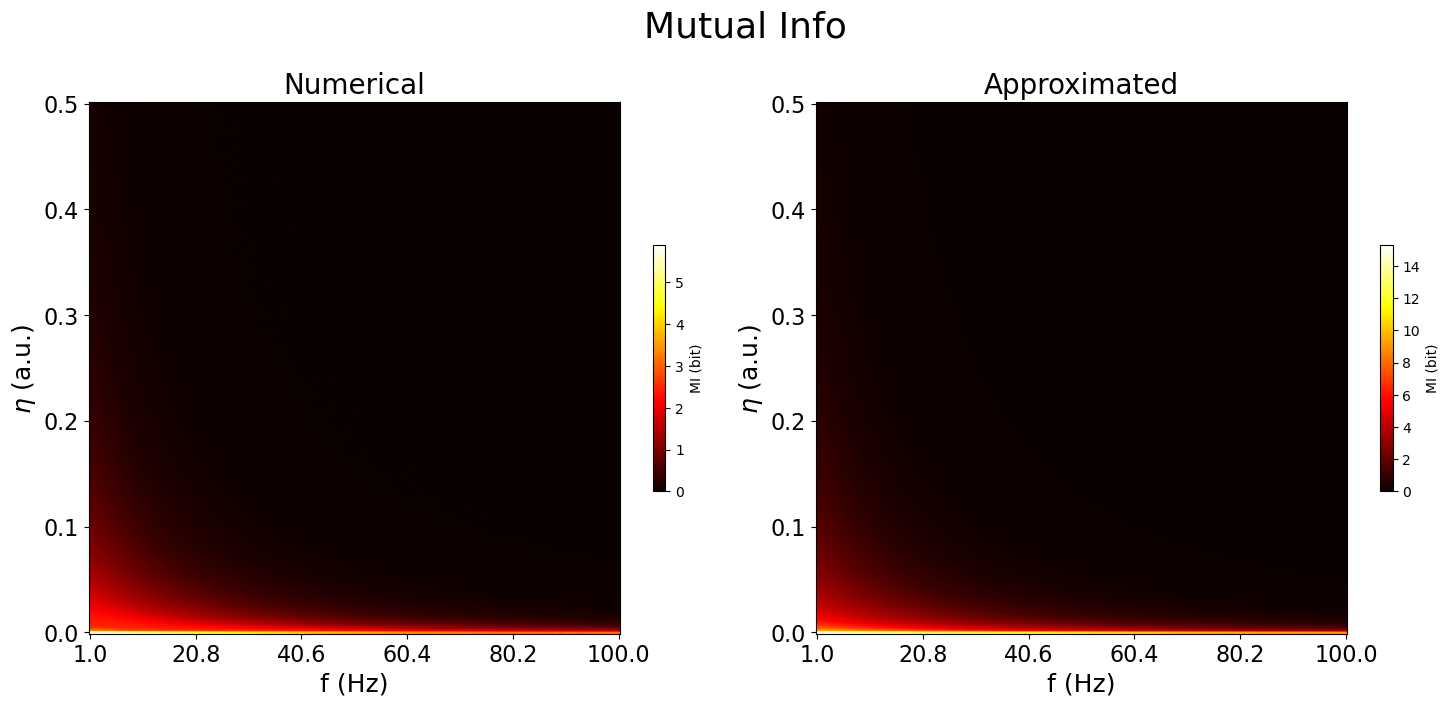

In [168]:
plt.figure(figsize=(15,7))

plt.suptitle("Mutual Info", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(mis_numerical, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (bit)', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(mis_approx, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (bit)', shrink=.4)


plt.tight_layout()
plt.show()

In [176]:
info_rate_approx_norm = get_R(mis_approx, fs, tau_x, norm=True)
info_rate_numerical_norm = get_R(mis_numerical, fs, tau_x, norm=True)

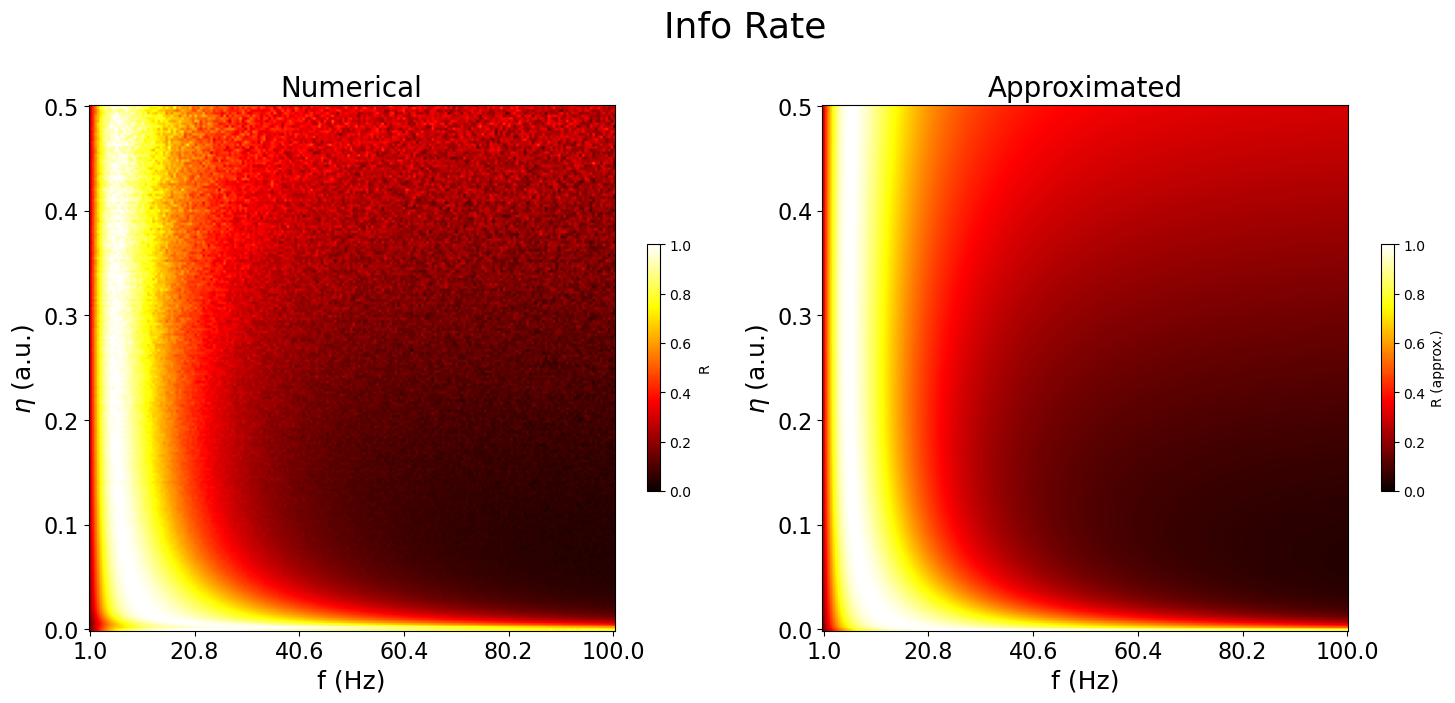

In [177]:
plt.figure(figsize=(15,7))

plt.suptitle("Info Rate", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(info_rate_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='R', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(info_rate_approx_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='R (approx.)', shrink=.4)


plt.tight_layout()
plt.show()

In [210]:
optimal_fs_ = []
tau_x_range = np.array([200, 100, 50, 25, 12])*1e-3
for tau_x_ in tau_x_range:
    info_rate_approx_norm_ = get_R(mis_approx, fs, tau_x_, norm=True)
    optimal_fs_.append(fs[np.argmax(info_rate_approx_norm_, axis=1)])

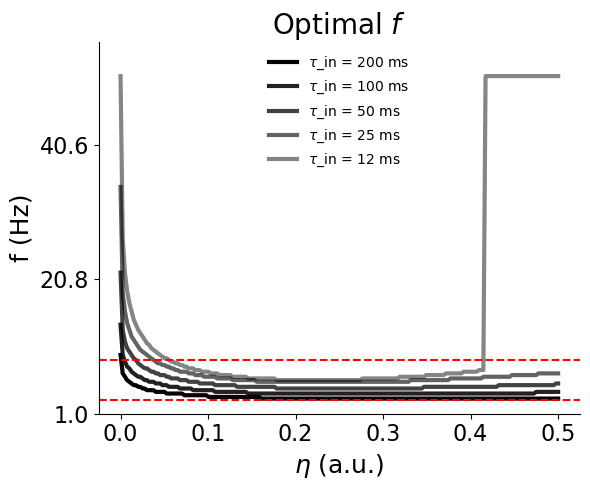

In [235]:
plt.figure(figsize=(6,5))

plt.title('Optimal $f$', fontsize=20)

for i, tau_x_ in enumerate(tau_x_range):
    plt.plot(optimal_fs_[i], linewidth=3, color='k', alpha=1-(1.3*i/10), label='$τ$_in = '+str(int(tau_x_*1e3))+' ms')

plt.yticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.ylabel('f (Hz)', fontsize=18)
plt.xlabel('$\eta$ (a.u.)', fontsize=18)

plt.axhline(2*2, color='r', linestyle='--')
plt.axhline(2*8, color='r', linestyle='--')

plt.ylim(0,110)

plt.legend(fontsize=10, frameon=False)

plt.tight_layout()
sb.despine()
plt.show()

## Simulation

In [44]:
def simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N, dt, t, n_neurons):
    V = np.zeros(n_neurons)
    first_spike_phase = np.empty(n_neurons, dtype='object')
    first_spike_phase[:] = None
    phi_0 = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    sigma_W = eta * V_th / np.sqrt(tau_m)
    has_spiked = np.zeros(n_neurons, dtype=bool)
    for i in range(len(t)):
        xi = np.random.normal(0, 1/np.sqrt(dt), n_neurons)
        I_theta = I_osc * np.cos(omega * t[i] - np.pi + phi_0)
        #I_AHP = amp_AHP * np.exp(-t[i]/tau_AHP)
        dV_dt = (-V + R_m * I_theta + R_m * I_s + tau_m * sigma_W * xi) / tau_m
        V += dV_dt * dt
    
        spiked = V >= V_th
        if np.any(spiked):
            V[spiked] = 0 
            if (omega * t[i] - np.pi + phi_0) > np.pi:
                mask = spiked & (first_spike_phase == None)
                first_spike_phase[mask] = (omega * t[i] + phi_0) % (2*np.pi)

                if np.all(first_spike_phase != None):
                    break
                
    return first_spike_phase

In [45]:
def get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac):
    omega = 2*np.pi*f
    I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, N)
    
    means = []
    variances = []
    all_first_spike_phases = []
    for I_s in Is_range:
        first_spike_phases = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N, dt, t, num_trials)
        first_spike_phases = np.where(first_spike_phases == None, np.nan, first_spike_phases)
        all_first_spike_phases.append(first_spike_phases)  
        means.append( np.nanmean(first_spike_phases) )
        variances.append( np.nanvar(first_spike_phases) )
        
    return np.array(means), np.array(variances), all_first_spike_phases

In [46]:
eta = 0.04             # a.u  //  sigma_w = 0.012-0.015 V/sqrt(s), acoording to Lansky et al (2006). eta=0.124-0.155 a.u.
f = 10  
#I_osc = 40 * 1e-12     # pA

# Simulation parameters
dt = 1e-4            # Time step for numerical integration
t_end = 2 / f        # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 5000     # Number of trials

In [47]:
means, variances, all_phis = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac)

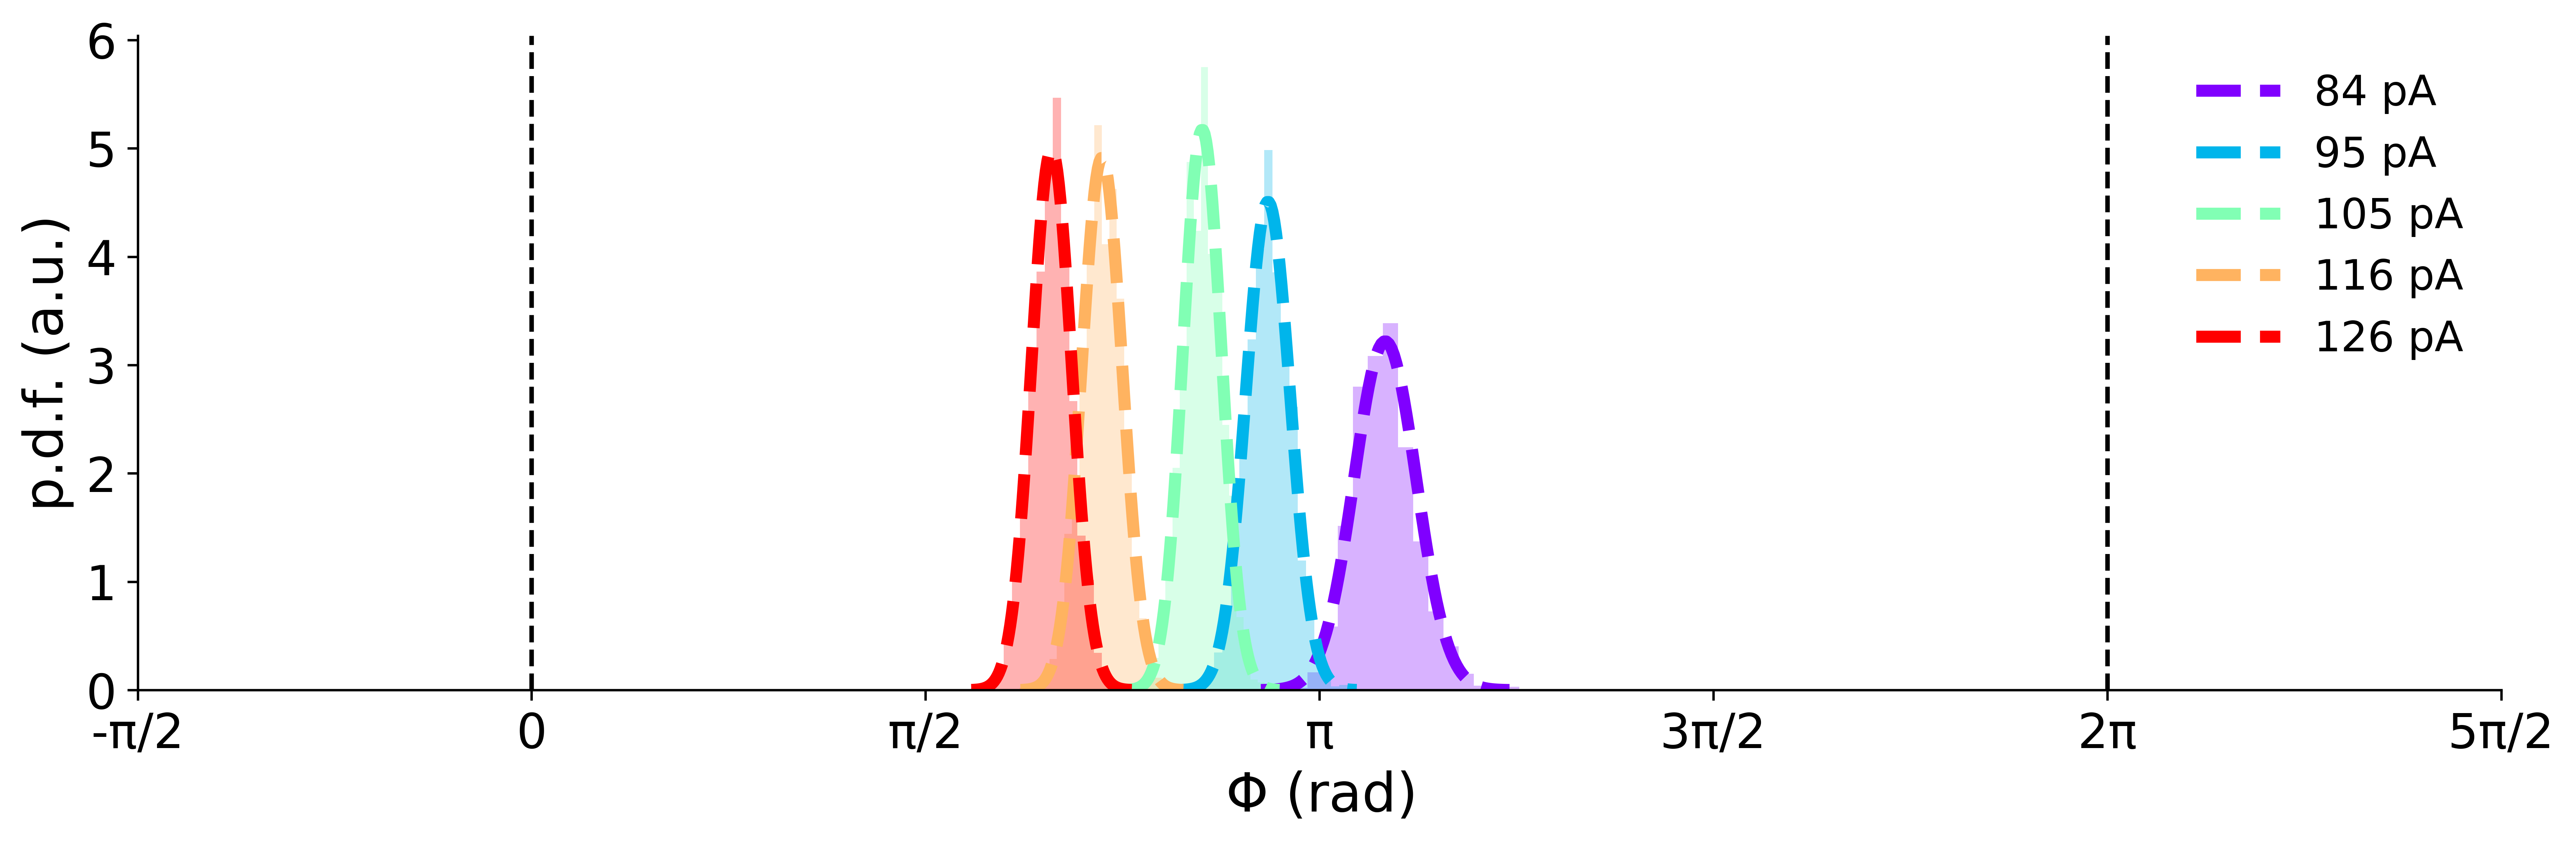

In [48]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, N)
c = cm.rainbow(np.linspace(0, 1, N))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")
    plt.hist(all_phis[i], bins=20, density=True, color=c[i], alpha=.3)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
#plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
plt.show()

#### Noise-frequency grid

In [171]:
# Simulation parameters
dt = 1e-4            # Time step for numerical integration
num_trials = 1000    # Number of trials
N = 10

In [174]:
res = 50
fs = np.linspace(1, 50, res)
etas = np.linspace(0.05, 0.4, res)
info_rate_empirical_approx = np.zeros((res,res))
info_rate_empirical_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        means, variances, all_phis = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac)
        info_rate_empirical_approx[i, j] = f * approx_mi(means, variances)
        info_rate_empirical_numerical[i, j] = f * numerical_mi(means, variances)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [175]:
info_rate_empirical_approx_norm = np.zeros_like(info_rate_empirical_approx)  
for index, row in enumerate(info_rate_empirical_approx):
    info_rate_empirical_approx_norm[index, :] = row/np.max(row)
    
info_rate_empirical_numerical_norm = np.zeros_like(info_rate_empirical_numerical)
for index, row in enumerate(info_rate_empirical_numerical):
    info_rate_empirical_numerical_norm[index, :] = row/np.max(row)

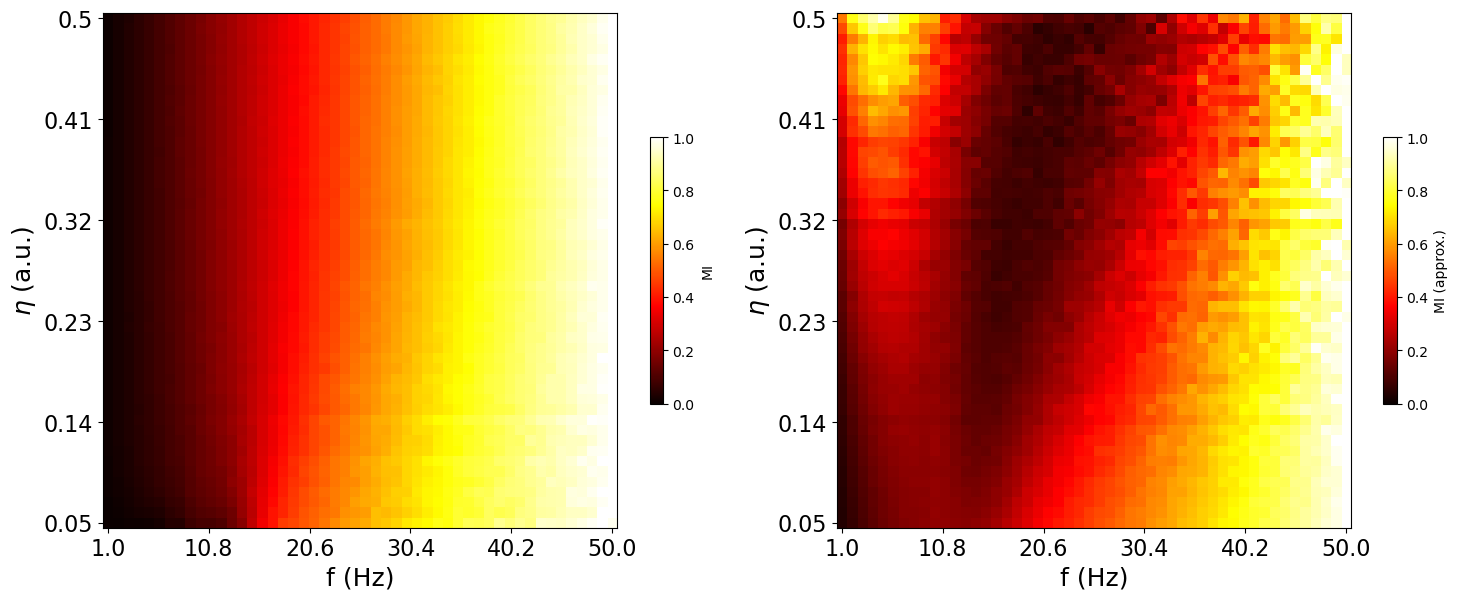

In [176]:
plt.figure(figsize=(15,7))


plt.subplot(121)
plt.imshow(info_rate_empirical_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI', shrink=.4)


plt.subplot(122)
plt.imshow(info_rate_empirical_approx_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (approx.)', shrink=.4)


plt.tight_layout()
#plt.savefig('empirical_mi.png', dpi=600)
plt.show()

## Frequency analysis

In [42]:
def cutoff_frequency(tau_m):
    '''
    Frequency where the power falls to 1/2 (or the amplitude falls to 1/sqrt(2)) of the maximum 
    '''
    return 1 / (2 * np.pi * tau_m)


def amplitude_mem_potential(R_m, I_osc, tau_m, f):
    A = 1 / np.sqrt(1 + (tau_m * 2 * np.pi * f)**2)
    amplitude = R_m * I_osc * A
    return amplitude

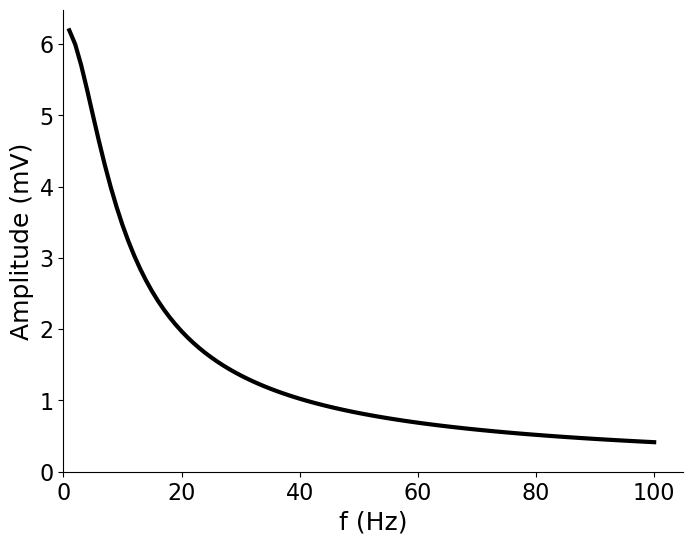

In [19]:
fs = np.linspace(1,100,100)
amp = amplitude_mem_potential(R_m, I_osc, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, amp*1e3, color='k', linewidth=3)

#plt.hlines(y=1/np.sqrt(2), xmin=0, xmax=cutoff_frequency(tau_m), linestyle='--', color='r', linewidth=1)

plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('Amplitude (mV)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.xlim(0)

sb.despine()
plt.savefig('amp.png', dpi=600)
plt.show()

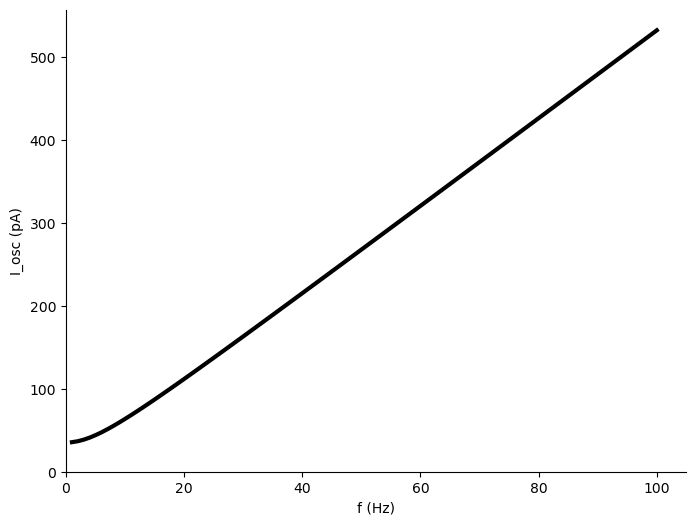

In [179]:
fs = np.linspace(1,100,100)
v_osc_amp = 5 * 1e-3   # mV

I_oscs = compute_Iosc(v_osc_amp, R_m, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, I_oscs*1e12, color='k', linewidth=3)

plt.xlabel('f (Hz)')
plt.ylabel('I_osc (pA)')
plt.ylim(0)
plt.xlim(0)

sb.despine()
plt.show()